# Wide field neurons analysis and plot

This code takes all wide field presynaptic partners of a certain neuron and visualizes connections

In [1]:
# Importing packages
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
import seaborn as sns
from fafbseg import flywire
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')
from openpyxl import load_workbook
from synapse_queries_helper import combine_xyz, calculate_neuron_weights, match_all_pre_to_single_post, calculate_spatial_span
from helper import replace_outliers_with_nan
import navis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


## Presynaptic partner visualization

In [2]:
# Loading data
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")

current_data = 'Tm9_700_R_20231113.xlsx'  # 'Tm9_700_healthy_L3_R_20231113.xlsx' ,'Tm9_700_R_20231113.xlsx'

filePath =  os.path.join(dataPath,current_data)
_sheet_name = 'Relative_counts'

data_df = pd.read_excel(filePath, sheet_name=_sheet_name,index_col = 0)
#data_df = data_df.fillna(0)
display(data_df.head())
number_of_columns = len(data_df)
pre_partners_ls = data_df.columns.tolist()
print(f'Total number of columns: {number_of_columns}')
print(f'All presynatic partners: \n {pre_partners_ls}')

,Tm16,Mi4,CT1,L3,Dm12,C3,Tm20,Tm1,ML1,PS125,...,Dm14,Dm8,L1,TmY25,TmY27,TmY22,Dm2,Dm1,TmY18,MeMe
instance_post,,,,,,,,,,,,,,,,,,,,,
Tm9::R100:D,10.82,17.12,8.11,22.52,NaN,3.60,3.60,2.70,4.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R101:V,NaN,21.70,12.26,26.42,2.83,3.77,2.83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R102:V,5.31,8.85,13.27,30.09,2.65,7.08,6.19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R103:V,NaN,9.09,11.11,29.29,NaN,NaN,4.04,NaN,NaN,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R104:V,6.34,7.75,9.86,23.94,2.11,5.63,NaN,2.11,2.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total number of columns: 700
All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10', 'Dm10', 'Mi9', 'Y3', 'T2', 'Tm23', 'TmY14', 'Dm3', 'Mi10', 'TmY11', 'Dm4', 'Tm4', 'Mi14', 'T5a', 'Dm15', 'Mi1', 'Dm20', 'Tm1a', 'Mi8', 'T5', 'Dm13', 'L2', 'Dm9', 'LC14b', 'Tm9', 'Tm5', 'Pm1a', 'T5c', 'T2a', 'T5b', 'TmY3', 'Lawf1', 'Tm5b', 'glia', 'R8', 'MeTu_m_l', 'Mt-N.I.', 'TmY21', 'TmY26', 'Me-Lo-2-N.I.', 'TmY24', 'TmY28', 'T3', 'TmY23', 'Mi?', 'glia ', 'Dm14', 'Dm8', 'L1', 'TmY25', 'TmY27', 'TmY22', 'Dm2', 'Dm1', 'TmY18', 'MeMe']


In [5]:
# Selecting neurons of interest
# order = ['Dm12','Dm10','Dm20','Dm4','Dm3','Dm13',
#          'Dm15','Dm9','Dm14','Dm8','Dm1','Dm2', 'Tm16', 'Mi13']
# data_df = data_df[order].copy()

# Applying a presence threshold based on NaN values
percetatge_prescence = 0.05
threshold = percetatge_prescence * len(data_df)

# Filter columns based on the threshold
filtered_data_df = data_df.dropna(thresh=threshold, axis=1)
filtered_pre_partners_ls = filtered_data_df.columns.tolist()
print(f'All presynatic partners: \n {filtered_pre_partners_ls}')

All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10']


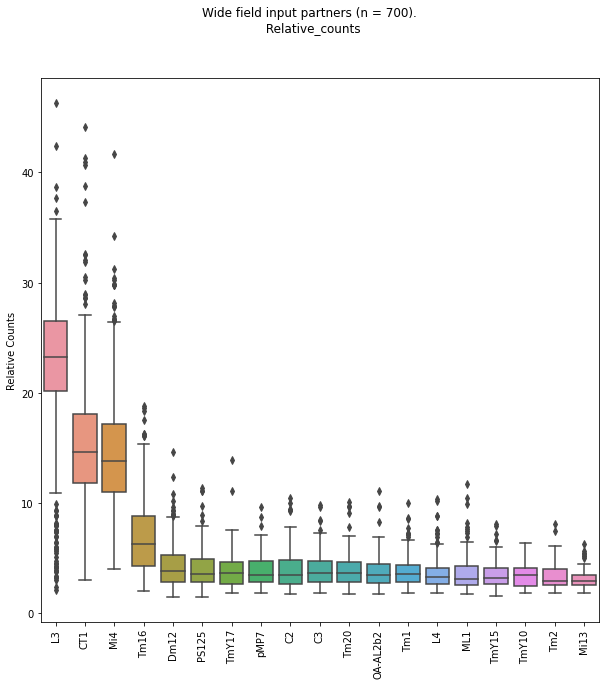

In [4]:
# Visualization
# Adjust subplot spacing and rotate x-axis labels
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)


major_inputs_data = filtered_data_df
#major_inputs_data = filtered_data_df[['L3', 'Mi4', 'CT1', 'Tm16', 'Dm12']]

sns.boxplot(data=major_inputs_data[major_inputs_data.mean().sort_values(ascending = False).index], ax=axs)
axs.set_ylabel('Relative Counts')
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)  # Rotate x-axis labels   

fig.suptitle(f'Wide field input partners (n = {number_of_columns}). \n {_sheet_name}')
plt.show()

## Anatomical RF size analysis

In [2]:
#For analysis purposes
min_desired_count = 3 # minimun desired number of contacts between pre and post neurons to be considered
single_column_diameter = 11.2 # in um (measured in FlyWire)
single_column_area = 100 # in um^2 (Assumed column as circle)


save_figures = False

# For plotting purposes

hemisphere = 'R' # 'R', 'L'
neuropile_mesh = 'ME_L'
mesh_azim = 16# -18 for ME_R, 16 for ME_L
mesh_elev = -50 # -148 for ME_R, -50 for ME_L

Consider updating your ids in the original pre-neuron data set:


Updating:   0%|          | 0/110 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
8,720575940633681235,720575940633782436,1.00,True
9,720575940627971709,720575940621626560,1.00,True
18,720575940625057515,720575940633605663,1.00,True
20,720575940614311661,720575940639070554,1.00,True
29,720575940612811925,720575940640957016,1.00,True
33,720575940618740507,720575940622146470,1.00,True
39,720575940631099708,720575940633977645,1.00,True
46,720575940629488646,720575940615956118,1.00,True
55,720575940622687220,720575940630032144,1.00,True
67,720575940606569318,720575940628822088,1.00,True


Consider updating your ids in the original post neuron data set:


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
488,720575940616417653,720575940608436914,0.98,True
651,720575940639208169,720575940618614969,0.98,True


Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Quick visualization of presynaptic partner weight


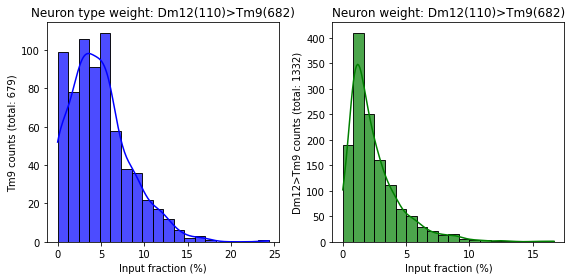

Pre-post match example after min syn fiter:


,post_pt_root_id,pre_pt_root_id,pre_syn_count
0,720575940600084489,720575940620506704,3
1,720575940600084489,720575940622432895,3
2,720575940600084489,720575940633977645,8
3,720575940602880736,720575940612534641,3
4,720575940602880736,720575940619165509,3


Fetching synapses:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating spatial span


In [3]:
#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########


## Loading information  from excel files
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
date = '20230912'
pre_neuron_type = 'Dm12'
post_neuron_type = 'Tm9'
fileName_post = f'{post_neuron_type} proofreadings.xlsx'
filePath_post = os.path.join(dataPath,fileName_post)
fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
filePath_pre = os.path.join(dataPath,fileName_pre)

#Loading file as DataFrame
post_df = pd.read_excel(filePath_post)
pre_df = pd.read_excel(filePath_pre)

## Filtering data
# Selecting the R optic lobe IDs
R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
# Selecting the backbone proofread IDs
R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
#R_post_df = R_post_df[R_post_df['patch_id'] == 'D']
# Selecting presynaptic cells ids
pre_ids = R_pre_df['Updated_seg_id'].tolist()

# Quick updates
# Updating presynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
    print('Consider updating your ids in the original pre-neuron data set:')
    pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    display(pre_ids_update_df[pre_ids_update_df['changed'] == True])
else:
    up_to_date_pre_ids = [int(x) for x in pre_ids]
    print('All pre ids were up to date')
    

    ## Getting postsynaptic side ID
post_ids = R_post_df['Updated_seg_id'].tolist()

## Updating postsynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
    print('Consider updating your ids in the original post neuron data set:')
    #Updating the IDs via Fafbseg
    post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_post_ids = post_ids_update_df['new_id']
    display(post_ids_update_df[post_ids_update_df['confidence'] < 1])
else:
    up_to_date_post_ids = [int(x) for x in post_ids]
    print('All post ids were up to date')
    

## Doing the pre to post match
pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

#############################################################################################
#### Quick visualization of presynaptic partner weight to postsynaptoc cell of interest ####

## Data analysis
neuron_weight_df, rel_neuron_type_weight = calculate_neuron_weights(pre_post_counts, post_inputs, 
                                                                    up_to_date_pre_ids, min_desired_count)

## Plot

# Calculate the percentage values
rel_neuron_type_weight_percent = [x * 100 for x in rel_neuron_type_weight] 
rel_neuron_weight_percent = [x * 100 for x in neuron_weight_df['rel_weight']] 

# Create subplots for each dimension using Seaborn
print('Quick visualization of presynaptic partner weight')
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(rel_neuron_type_weight_percent, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Neuron type weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{post_neuron_type} counts (total: {len(rel_neuron_type_weight_percent)})')  # Update the x-axis label

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(rel_neuron_weight_percent, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Neuron weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{pre_neuron_type}>{post_neuron_type} counts (total: {len(rel_neuron_weight_percent)})')  # Update the x-axis label

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


#############################################################################################
## Analysis f spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

# Synaptic counts filter
pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()
print('Pre-post match example after min syn fiter:')
display(pre_post_counts.head())

## Geeting information for all pre cells 
pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

# Fetch the inputs from presynaptic cells
#TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filtering: keeping only synapses in the medulla
pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
len(pre_inputs)

#Combining pre- and postsynpases XYZ values in single columns
combine_xyz(pre_inputs) # Function that does the operation

## Quantificatino of the spatial span
spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)



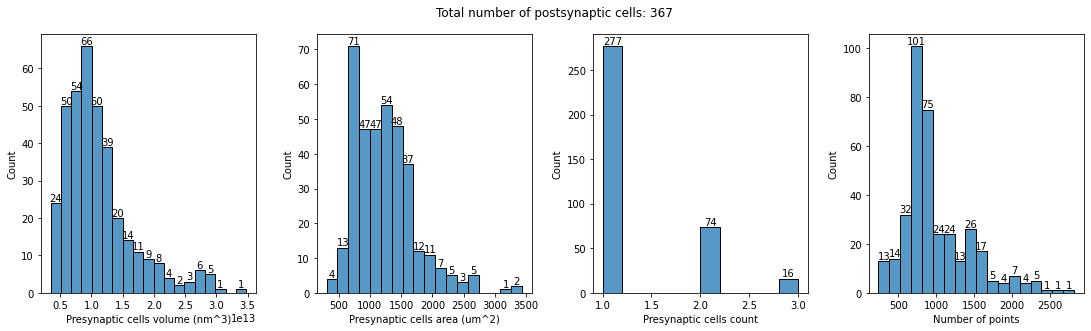

In [4]:
################################################################################################
#################    Brief spatial span statistics visualization with seaborn   ################

# Data
_data = spatial_span_df.copy()
#_data = _data[_data['Pre_count'] == 1.0] # Filtering in columns wiht single presynaptic partner

# Plot
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (40*cm, 12*cm))
fig.tight_layout(pad=3)
fig.suptitle(f"Total number of postsynaptic cells: {len(_data [~np.isnan(_data['Area'])])}")

# Plot histograms and annotate bars in each subplot
histograms = [_data['Volume'], _data['Area'], _data['Pre_count'],_data['Num_pre_sites']]
subplot_labels = ['Presynaptic cells volume (nm^3)', 'Presynaptic cells area (um^2)', 'Presynaptic cells count', 'Number of points']


for i, data in enumerate(histograms):
    sns.histplot(data, ax=axs[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(subplot_labels[i])
    
    # Annotate the bars with counts for bars with height > 0
    for p in axs[i].patches:
        if p.get_height() > 0:
            axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

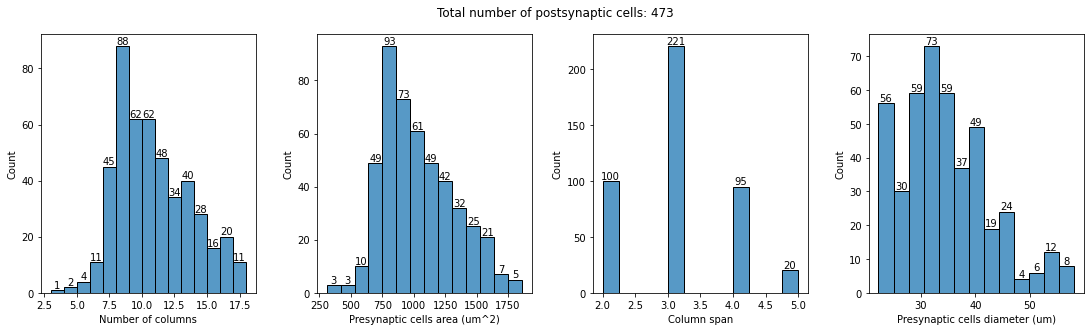

In [5]:
################################################################################################
#################    Brief spatial span statistics visualization with seaborn   ################

# Plot
filter_ouliers = True
cm = 1/2.54  # centimeters in inches

# Data
_data = individual_spatial_span_df.copy()

#Outlier filter
if filter_ouliers:
    _data = replace_outliers_with_nan(_data, multiplier=1.5)



fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (40*cm, 12*cm))
fig.tight_layout(pad=3)
fig.suptitle(f"Total number of postsynaptic cells: {len(_data [~np.isnan(_data['Area'])])}")

# Plot histograms and annotate bars in each subplot
histograms = [_data['Num_columns'], _data['Area'], _data['Column_span'],_data['Diameter']]
subplot_labels = ['Number of columns', 'Presynaptic cells area (um^2)', 'Column span', 'Presynaptic cells diameter (um)']
histograms_bin_width = [None,None,None,None]

for i, data in enumerate(histograms):
    sns.histplot(data,binwidth=histograms_bin_width[i], ax=axs[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(subplot_labels[i])
    
    # Annotate the bars with counts for bars with height > 0
    for p in axs[i].patches:
        if p.get_height() > 0:
            axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

In [8]:
########## Looping across all presynaptic cell types


#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########

pre_neuron_type_ls = ['L3','Mi4','Tm16','Dm12','C2','C3', 'L4','Mi13','Tm1','Tm20','TmY10','TmY15','TmY17']
#pre_neuron_type_ls = ['L3','Mi4','Tm16']


spatial_span_df_dict = {}
individual_spatial_span_df_dict = {}

for pre_neuron_type in pre_neuron_type_ls:
    print(f'Analyzing {pre_neuron_type}')

    ## Loading information  from excel files
    PC_disc = 'D'
    dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
    date = '20230912'
    post_neuron_type = 'Tm9'
    fileName_post = f'{post_neuron_type} proofreadings.xlsx'
    filePath_post = os.path.join(dataPath,fileName_post)
    fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
    filePath_pre = os.path.join(dataPath,fileName_pre)

    #Loading file as DataFrame
    post_df = pd.read_excel(filePath_post)
    pre_df = pd.read_excel(filePath_pre)

    ## Filtering data
    # Selecting the R optic lobe IDs
    R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
    R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
    # Selecting the backbone proofread IDs
    R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
    # Selecting presynaptic cells ids
    pre_ids = R_pre_df['Updated_seg_id'].tolist()

    # Quick updates
    # Updating presynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
        print('Consider updating your ids in the original pre-neuron data set')
        pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    else:
        up_to_date_pre_ids = [int(x) for x in pre_ids]
        print('All pre ids were up to date')


        ## Getting postsynaptic side ID
    post_ids = R_post_df['Updated_seg_id'].tolist()

    ## Updating postsynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
        print('Consider updating your ids in the original post neuron data set')
        #Updating the IDs via Fafbseg
        post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_post_ids = post_ids_update_df['new_id']
    else:
        up_to_date_post_ids = [int(x) for x in post_ids]
        print('All post ids were up to date')


    ## Doing the pre to post match
    pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

    #############################################################################################
    ## Analysis f spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

    # Synaptic counts filter
    pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()

    ## Geeting information for all pre cells 
    pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

    # Fetch the inputs from presynaptic cells
    #TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
    pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                                 min_score=50, clean=True, transmitters=False, 
                                                 neuropils=True, batch_size=30, 
                                                 dataset='production', progress=True,mat= "live")

    # Filtering: keeping only synapses in the medulla
    pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
    len(pre_inputs)

    #Combining pre- and postsynpases XYZ values in single columns
    combine_xyz(pre_inputs) # Function that does the operation

    ## Quantificatino of the spatial span
    spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)
    spatial_span_df_dict[pre_neuron_type] = spatial_span_df
    individual_spatial_span_df_dict[pre_neuron_type] = individual_spatial_span_df
    
print('Analysis done.')
    

Analyzing L3
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/685 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/22 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Mi4
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/777 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/27 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm16
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/194 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/33 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Dm12
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/110 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating spatial span
Analyzing C2
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/750 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating spatial span
Analyzing C3
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/765 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/12 [00:00<?, ?it/s]

Calculating spatial span
Analyzing L4
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/719 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Mi13
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/365 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm1
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/743 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm20
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/732 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/12 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY10
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/237 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY15
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/152 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY17
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/156 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating spatial span
Analysis done.


L3


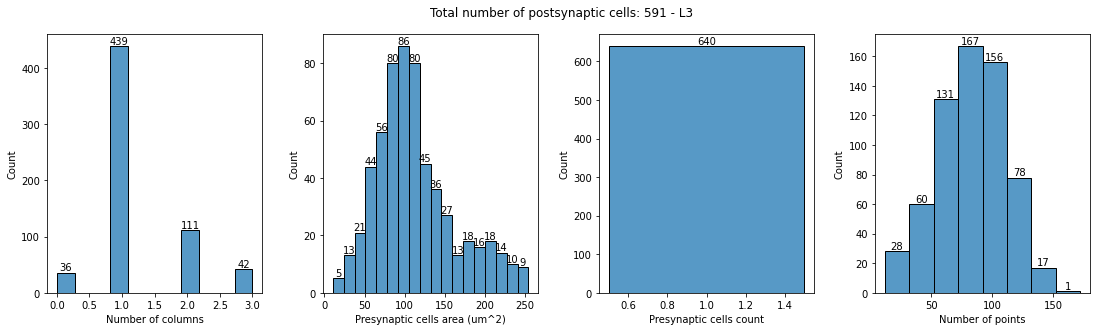

Mi4


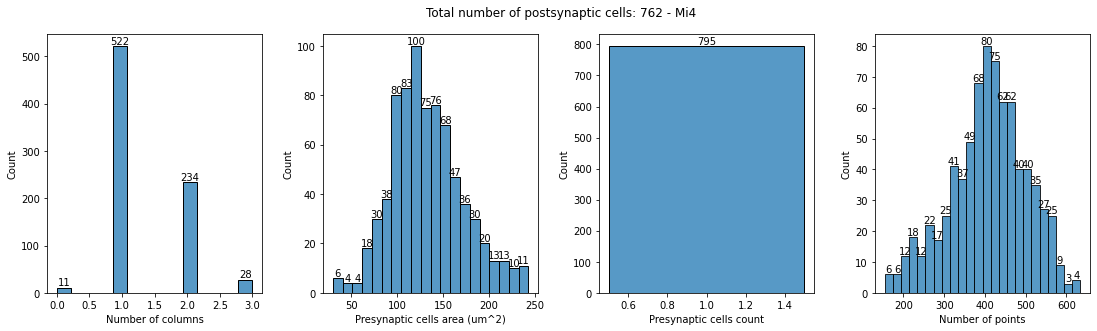

Tm16


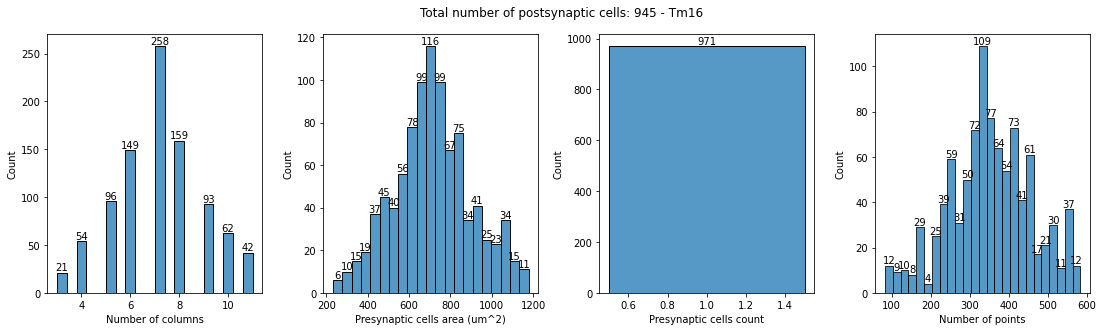

Dm12


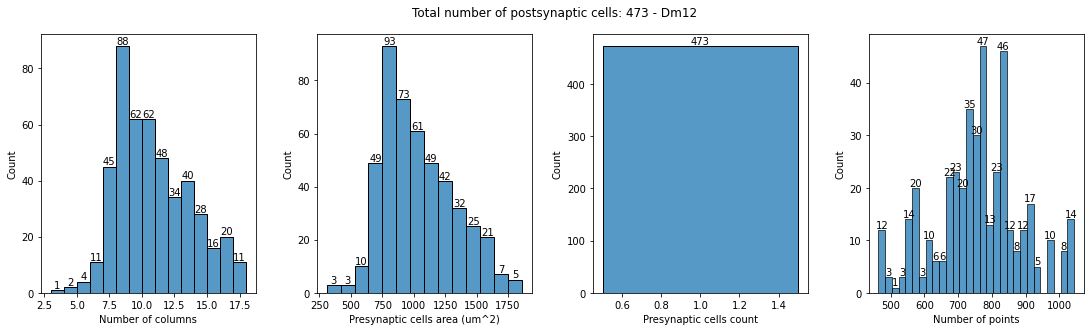

C2


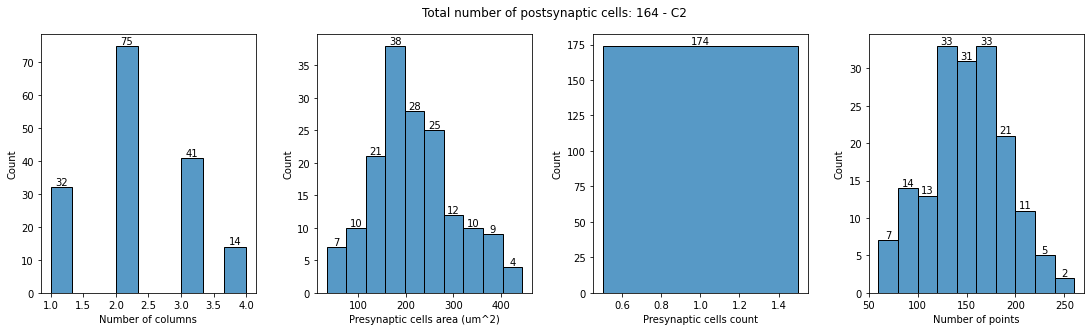

C3


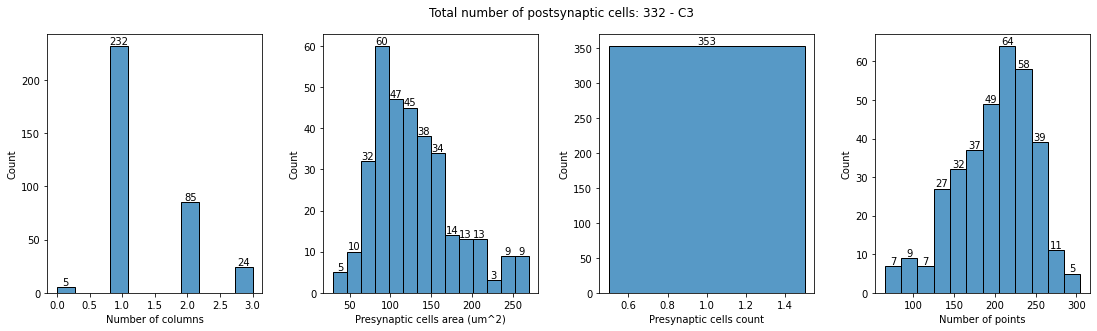

L4


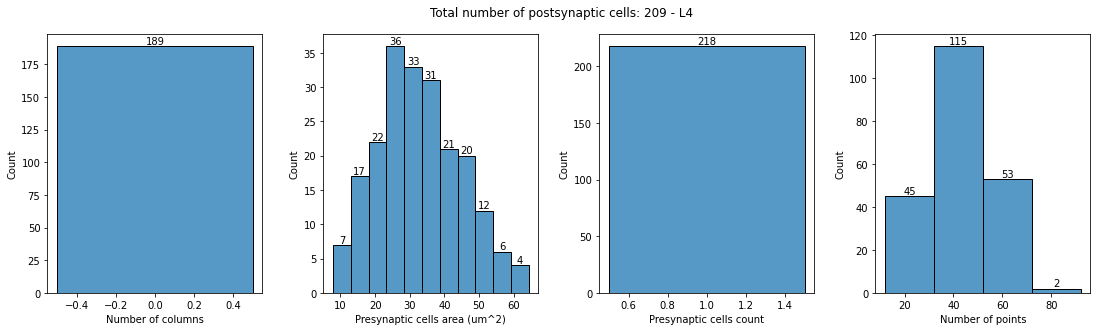

Mi13


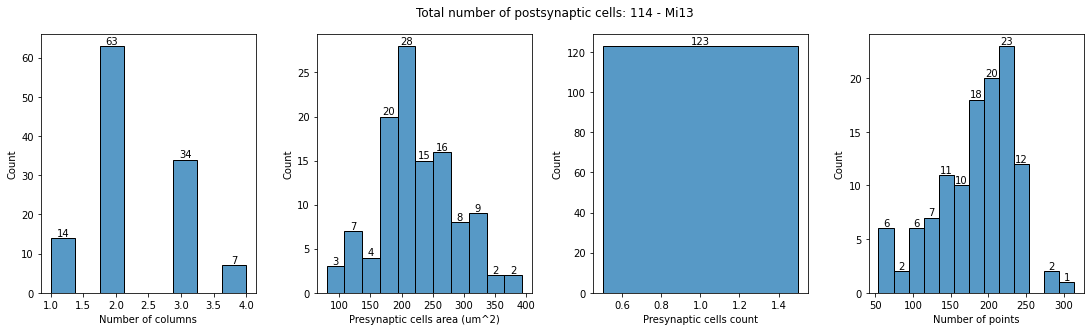

Tm1


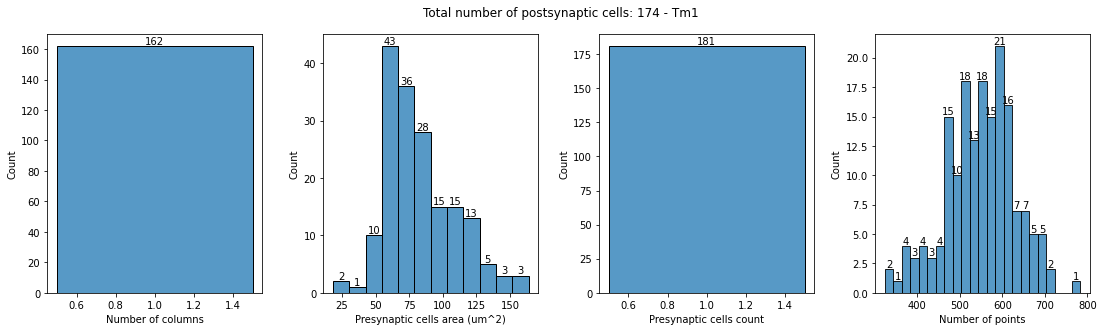

Tm20


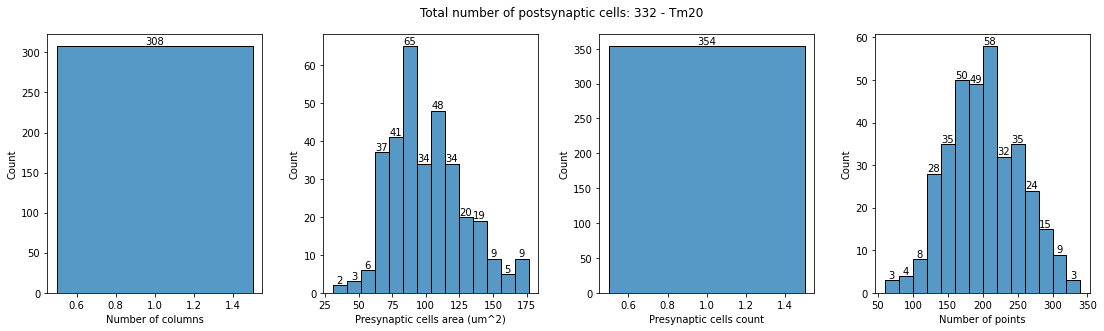

TmY10


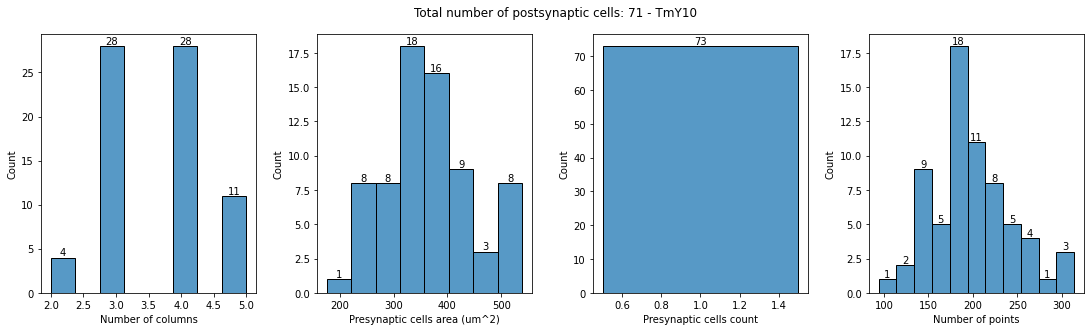

TmY15


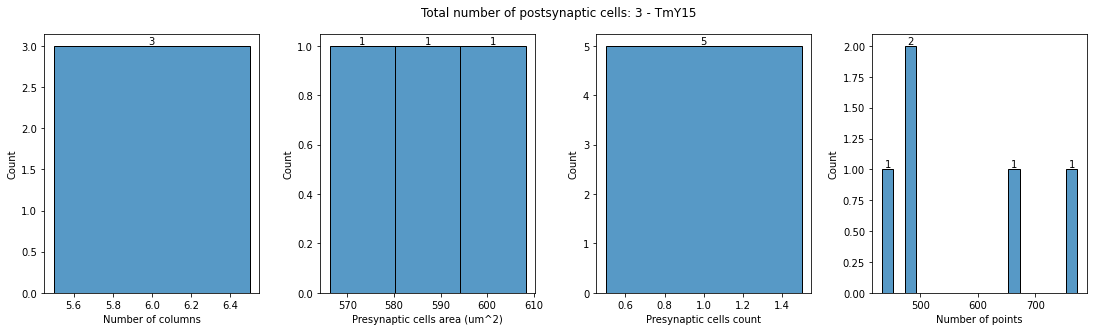

TmY17


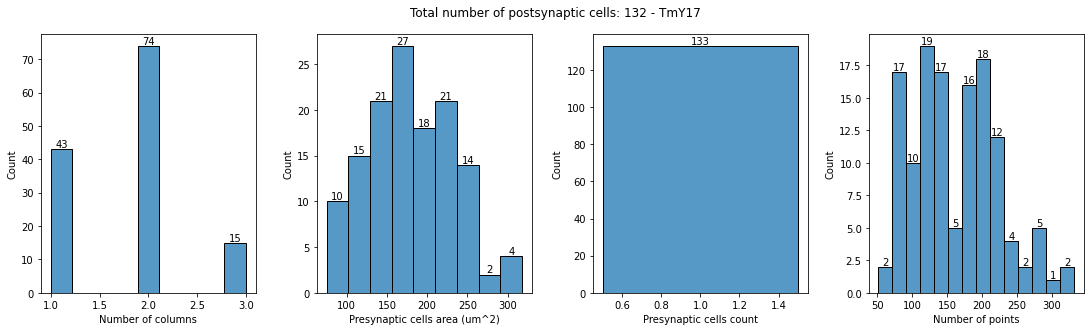

In [9]:
# Plot
cm = 1/2.54  # centimeters in inches
filter_ouliers = True

# Iterate over the keys and corresponding dataframes in the dictionary
for key, _data in individual_spatial_span_df_dict.items():
    print(key)
    
    #Outlier filter
    if filter_ouliers:
        _data = replace_outliers_with_nan(_data, multiplier=1.5)
        

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(40*cm, 12*cm))
    fig.tight_layout(pad=3)
    fig.suptitle(f"Total number of postsynaptic cells: {len(_data[~np.isnan(_data['Area'])])} - {key}")

    # Plot histograms and annotate bars in each subplot
    histograms = [_data['Num_columns'], _data['Area'], _data['Pre_count'], _data['Num_pre_sites']]
    subplot_labels = ['Number of columns', 'Presynaptic cells area (um^2)', 'Presynaptic cells count', 'Number of points']
    histograms_bin_width = [None,None,None,20]

    for i, data in enumerate(histograms):
        sns.histplot(data, binwidth=histograms_bin_width[i],  ax=axs[i])
        axs[i].set_ylabel('Count')
        axs[i].set_xlabel(subplot_labels[i])

        # Annotate the bars with counts for bars with height > 0
        for p in axs[i].patches:
            if p.get_height() > 0:
                axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

    plt.show()

In [8]:
for key, _data in individual_spatial_span_df_dict.items():
    print(key)

L3
